# Test Inference for MDLM

This notebook loads a trained MDLM model from `outputs/mdlm/checkpoints/final`, performs iterative masked inference, and visualizes the top logits and entropy.


In [1]:
import os
import sys
import yaml
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from transformers import AutoTokenizer

# Add src to path
if "src" not in sys.path:
    sys.path.append(os.path.join(os.getcwd(), "src"))

from src.mdlm import MDLM

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if torch.backends.mps.is_available():
    device = torch.device("mps")
print(f"Using device: {device}")


/home/sagoyal/research/trm_vs_mdlm/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using device: cuda


In [4]:
# Load Configuration
with open("config.yaml", "r") as f:
    config = yaml.safe_load(f)

print("Model Config:", config["model"])

# Initialize Model
model = MDLM(config)
model.to(device)
model.eval()

# Load Checkpoint
checkpoint_path = "outputs/mdlm_baseline/checkpoints/step_30000"
# Try to find the checkpoint file
if os.path.isdir(checkpoint_path):
    # Check for various formats
    possible_files = ["pytorch_model.bin", "model.safetensors", "model.pt"]
    found = False
    for fname in possible_files:
        p = os.path.join(checkpoint_path, fname)
        if os.path.exists(p):
            print(f"Loading weights from {p}")
            # Use torch.load for .bin/.pt, safetensors requires loading differently usually but accelerate might save as .bin
            if fname.endswith(".safetensors"):
                from safetensors.torch import load_file
                state_dict = load_file(p)
            else:
                state_dict = torch.load(p, map_location=device)
            found = True
            break
    
    if not found:
        # Maybe it's an accelerator checkpoint with subfolders
        print(f"Warning: No standard model file found in {checkpoint_path}. Attempting to load using accelerate if needed or user intervention required.")
        # If it was saved with accelerator.save_state(), it might have multiple files.
        # But here we assume a gathered checkpoint or similar.
        # As fallback, just try loading 'pytorch_model.bin' even if os.path.exists failed (symlinks?)
        pass
else:
    print(f"Checkpoint path {checkpoint_path} does not exist. Please check path.")
    # For demonstration, we proceed with random weights if file missing, BUT user asked to load it.
    # We'll just define state_dict variable to None if not found

if 'state_dict' in locals():
    # If the state dict has 'model' key (common in some lighting/accelerate saves)
    if "model" in state_dict:
        state_dict = state_dict["model"]
    
    # MDLM wraps modules, keys might need adjustment
    # current model has: embeddings, backbone, output_head
    # state_dict should match
    keys = model.load_state_dict(state_dict, strict=False)
    print("Model loaded with keys:", keys)
else:
    print("Skipping weight loading (file not found). Using random initialization for demo.")

# Load Tokenizer
tokenizer = AutoTokenizer.from_pretrained(config["data"]["tokenizer"])
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token


Model Config: {'n_layers': 12, 'n_heads': 12, 'd_model': 768, 'd_ff': 3072, 'vocab_size': 50257, 'max_seq_len': 512, 'dropout': 0.1}
Loading weights from outputs/mdlm_baseline/checkpoints/step_30000/model.safetensors
Model loaded with keys: _IncompatibleKeys(missing_keys=['output_head.tie_weights'], unexpected_keys=[])


In [5]:
def get_logits_and_entropy(model, input_ids):
    """Run forward pass and compute logits and entropy."""
    with torch.no_grad():
        # MDLM structure: embeddings -> backbone -> output_head
        # We access components directly since MDLM.forward is for training loss
        
        # 1. Embeddings
        x = model.embeddings(input_ids)
        
        # 2. Backbone
        # Create attention mask (all 1s if not padding)
        attention_mask = torch.ones_like(input_ids)
        hidden = model.backbone(x, attention_mask)
        
        # 3. Output Head
        logits = model.output_head(hidden) # [B, L, V]
        
        # Compute Entropy
        probs = F.softmax(logits, dim=-1)
        log_probs = F.log_softmax(logits, dim=-1)
        entropy = -(probs * log_probs).sum(dim=-1) # [B, L]
        
    return logits, entropy

def print_top_k_for_token(logits, tokenizer, token_idx, top_k=10):
    """Print top K predictions for a specific token position."""
    token_logits = logits[0, token_idx]
    probs = F.softmax(token_logits, dim=-1)
    
    top_probs, top_indices = torch.topk(probs, top_k)
    
    print(f"Top {top_k} for position {token_idx}:")
    for prob, idx in zip(top_probs, top_indices):
        token = tokenizer.decode([idx])
        print(f"  {token!r}: {prob:.4f}")

def visualize_entropy(entropy, tokens, title="Entropy per Token"):
    """Plot entropy per token position."""
    entropy_np = entropy[0].cpu().numpy()
    
    plt.figure(figsize=(15, 5))
    plt.bar(range(len(entropy_np)), entropy_np)
    plt.xticks(range(len(entropy_np)), tokens, rotation=90)
    plt.title(title)
    plt.ylabel("Entropy (nats)")
    plt.tight_layout()
    plt.show()

def mask_text(input_ids, mask_token_id, mask_prob=0.15):
    """Randomly mask tokens."""
    # Create mask
    mask = torch.rand(input_ids.shape) < mask_prob
    masked_input = input_ids.clone()
    masked_input[mask] = mask_token_id
    return masked_input, mask


Original Text: The quick brown fox jumps over the lazy dog.
Input IDs: tensor([[  464,  2068,  7586, 21831, 18045,   625,   262, 16931,  3290,    13]],
       device='cuda:0')

==================== Step 1 ====================
Masked Input: The quick brown fox jumps over the lazy dog.


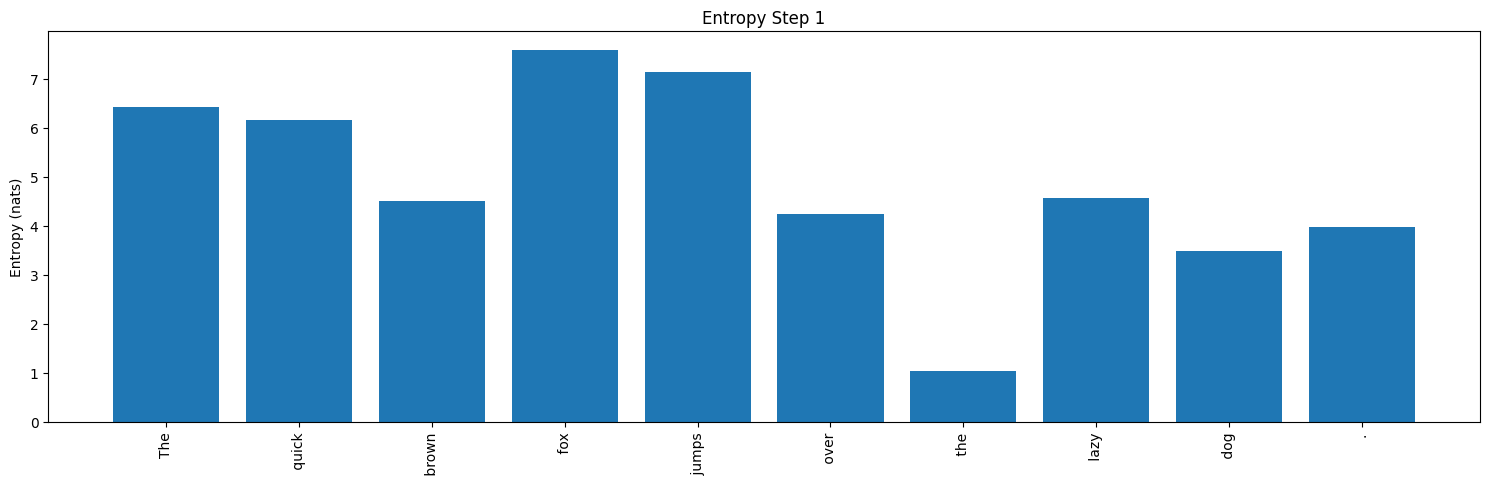

Predictions for selected positions:
Top 10 for position 5:
  ' over': 0.1934
  ' to': 0.1366
  ' from': 0.0697
  ' by': 0.0501
  ' off': 0.0465
  ' on': 0.0393
  ' the': 0.0283
  ' down': 0.0217
  ' around': 0.0164
  ' in': 0.0156
Top 10 for position 6:
  ' the': 0.8772
  ' a': 0.0349
  ' an': 0.0057
  ' your': 0.0031
  ' his': 0.0027
  ' its': 0.0025
  ' their': 0.0018
  ' dog': 0.0015
  'the': 0.0012
  ' this': 0.0011
Top 10 for position 7:
  ' dog': 0.4998
  ' dogs': 0.0304
  ' bad': 0.0236
  ' good': 0.0070
  ' your': 0.0052
  ' old': 0.0045
  ' puppy': 0.0044
  ' Dog': 0.0043
  ' adult': 0.0041
  ' little': 0.0037
Output Text: The quick brown fox jumps over the lazy dog.

==================== Step 2 ====================
Masked Input: The quick brown fox jumps over the lazy dog.


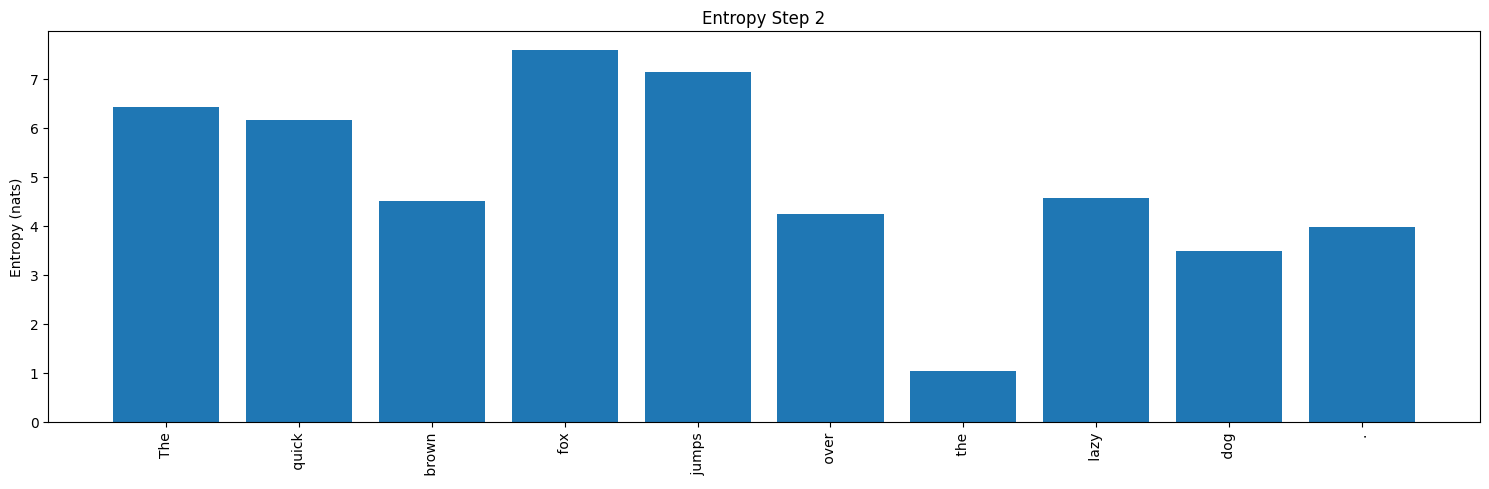

Predictions for selected positions:
Top 10 for position 5:
  ' over': 0.1934
  ' to': 0.1366
  ' from': 0.0697
  ' by': 0.0501
  ' off': 0.0465
  ' on': 0.0393
  ' the': 0.0283
  ' down': 0.0217
  ' around': 0.0164
  ' in': 0.0156
Top 10 for position 6:
  ' the': 0.8772
  ' a': 0.0349
  ' an': 0.0057
  ' your': 0.0031
  ' his': 0.0027
  ' its': 0.0025
  ' their': 0.0018
  ' dog': 0.0015
  'the': 0.0012
  ' this': 0.0011
Top 10 for position 7:
  ' dog': 0.4998
  ' dogs': 0.0304
  ' bad': 0.0236
  ' good': 0.0070
  ' your': 0.0052
  ' old': 0.0045
  ' puppy': 0.0044
  ' Dog': 0.0043
  ' adult': 0.0041
  ' little': 0.0037
Output Text: The quick brown fox jumps over the lazy dog.

==================== Step 3 ====================
Masked Input: The quick brown fox jumps over the lazy dog.


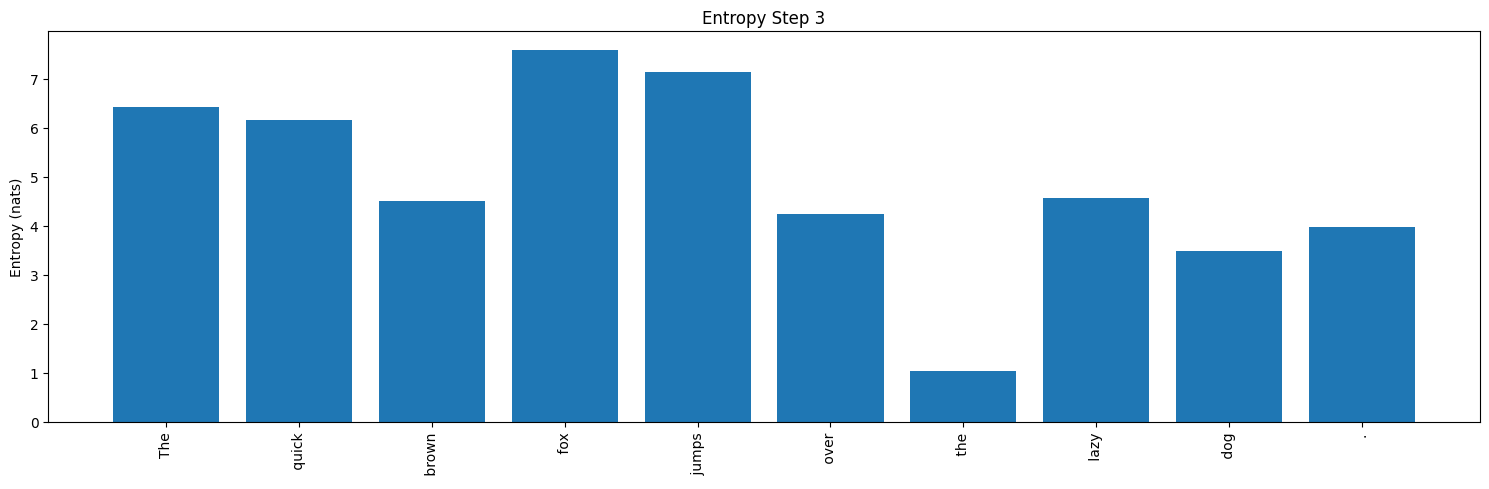

Predictions for selected positions:
Top 10 for position 5:
  ' over': 0.1934
  ' to': 0.1366
  ' from': 0.0697
  ' by': 0.0501
  ' off': 0.0465
  ' on': 0.0393
  ' the': 0.0283
  ' down': 0.0217
  ' around': 0.0164
  ' in': 0.0156
Top 10 for position 6:
  ' the': 0.8772
  ' a': 0.0349
  ' an': 0.0057
  ' your': 0.0031
  ' his': 0.0027
  ' its': 0.0025
  ' their': 0.0018
  ' dog': 0.0015
  'the': 0.0012
  ' this': 0.0011
Top 10 for position 7:
  ' dog': 0.4998
  ' dogs': 0.0304
  ' bad': 0.0236
  ' good': 0.0070
  ' your': 0.0052
  ' old': 0.0045
  ' puppy': 0.0044
  ' Dog': 0.0043
  ' adult': 0.0041
  ' little': 0.0037
Output Text: The quick brown fox jumps over the lazy dog.


In [6]:
# Configuration for Inference
initial_text = "The quick brown fox jumps over the lazy dog."
mask_probability = 0.0 # Mask X% of tokens each step
num_steps = 3
mask_token_id = 50256 # From config or tokenizer.eos_token_id usually 50256 for GPT2

# Prepare Input
input_ids = tokenizer.encode(initial_text, return_tensors="pt").to(device)
current_ids = input_ids.clone()

print(f"Original Text: {initial_text}")
print(f"Input IDs: {current_ids}")

# Iterative Loop
for step in range(num_steps):
    print(f"\n{'='*20} Step {step+1} {'='*20}")
    
    # 1. Mask Tokens
    # We mask a random subset of tokens
    masked_ids, mask_bool = mask_text(current_ids, mask_token_id, mask_probability)
    masked_ids = masked_ids.to(device)
    
    masked_text = tokenizer.decode(masked_ids[0])
    print(f"Masked Input: {masked_text}")
    
    # 2. Forward Pass
    logits, entropy = get_logits_and_entropy(model, masked_ids)
    
    # 3. Visualization
    # Visualize entropy
    tokens_str = [tokenizer.decode([t]) for t in masked_ids[0]]
    visualize_entropy(entropy, tokens_str, title=f"Entropy Step {step+1}")
    
    # Show Top 10 for masked positions (just the first few masked ones to save space)
    masked_indices = torch.where(mask_bool[0])[0]
    # if len(masked_indices) > 0:
    print("Predictions for selected positions:")
    for idx in range(5,8): # Show max 3
        print_top_k_for_token(logits, tokenizer, idx)
    # else:
    #     print("No tokens were masked this step.")

    # 4. Sampling / Update
    # We sample from the model's output to fill the masks
    # For unmasked tokens, we keep the original (or input)
    # This loop logic assumes we want to evolve the text
    
    probs = F.softmax(logits, dim=-1)
    sampled_ids = torch.multinomial(probs.view(-1, probs.size(-1)), 1).view(probs.size(0), -1)
    
    # Update current_ids: Keep unmasked, replace masked with sample
    # Note: mask_bool matches masked_ids
    current_ids = torch.where(mask_bool.to(device), sampled_ids.to(device), masked_ids.to(device))
    
    decoded_text = tokenizer.decode(current_ids[0])
    print(f"Output Text: {decoded_text}")

